In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle
import tensorflow as tf
import matplotlib.image as mpimg



In [2]:
from IPython.display import Image,display
listOfImageName=['/Users/meicg/Desktop/image/1100/335700201512260857赣G356181344.JPG',
                '/Users/meicg/Desktop/image/3601/360103201508031240赣A75M721208.JPG',
                '/Users/meicg/Desktop/image/3602/360200201512262247赣H051551301.JPG',
                '/Users/meicg/Desktop/image/3603/360302201601220143赣J655591636.JPG',
                '/Users/meicg/Desktop/image/3604/360423201512260847赣G5Y8301301.JPG']
for imageName in listOfImageName:
    display(Image(filename=imageName))
    
    

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe8 in position 50: ordinal not in range(128)

In [3]:
image_size = 128  # Pixel width and height.
channel = 3
pixel_depth = 255.0  # Number of levels per pixel.
folders = ['image_128/label_128_128_0',
            'image_128/label_128_128_1']

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.float32)
  original_dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size, channel), dtype=np.uint8)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print folder
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          num_images, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        original_data = mpimg.imread(image_file)
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size,channel):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :, :] = image_data
        original_dataset[image_index, :, :, :] = original_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :, :]
  original_dataset = original_dataset[0:num_images, :, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print 'Full dataset tensor:', dataset.shape
  print 'Full original dataset tensor:', original_dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return original_dataset,dataset, labels
original_dataset,dataset, labels = load(folders, 5000, 6000)

image_128/label_128_128_0
image_128/label_128_128_1
Full dataset tensor: (5564, 128, 128, 3)
Full original dataset tensor: (5564, 128, 128, 3)
Mean: -0.174292
Standard deviation: 0.213444
Labels: (5564,)


In [4]:
np.random.seed(133)
def randomize(original_dataset,dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_original_dataset = original_dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_original_dataset,shuffled_dataset, shuffled_labels
original_dataset,dataset, labels = randomize(original_dataset,dataset, labels)

In [5]:
train_size = 4500
valid_size = 500
test_size = 500

valid_dataset = dataset[:valid_size,:,:,:]
valid_labels = labels[:valid_size]
train_dataset = dataset[valid_size:valid_size+train_size,:,:,:]
train_labels = labels[valid_size:valid_size+train_size]
test_dataset = dataset[valid_size+train_size:train_size+valid_size+test_size,:,:,:]
test_labels = labels[valid_size+train_size:train_size+valid_size+test_size]

original_valid_dataset = original_dataset[:valid_size,:,:,:]
original_train_dataset = original_dataset[valid_size:valid_size+train_size,:,:,:]
original_test_dataset = original_dataset[valid_size+train_size:train_size+valid_size+test_size,:,:,:]


print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape
print 'Test', test_dataset.shape, test_labels.shape
print 'original_Training', original_train_dataset.shape
print 'original_Validation', original_valid_dataset.shape
print 'original_Test', original_test_dataset.shape

Training (4500, 128, 128, 3) (4500,)
Validation (500, 128, 128, 3) (500,)
Test (500, 128, 128, 3) (500,)
original_Training (4500, 128, 128, 3)
original_Validation (500, 128, 128, 3)
original_Test (500, 128, 128, 3)


In [6]:
num_labels = 2
num_channels = 3 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print 'Training set', train_dataset.shape, train_labels.shape
print 'Validation set', valid_dataset.shape, valid_labels.shape
print 'Test set', test_dataset.shape, test_labels.shape

Training set (4500, 128, 128, 3) (4500, 2)
Validation set (500, 128, 128, 3) (500, 2)
Test set (500, 128, 128, 3) (500, 2)


In [18]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [29]:
batch_size = 128
patch_size = 3
depth = 16
num_hidden = 512
lamada = 0.02
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  conv1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  conv1_biases = tf.Variable(tf.zeros([depth]))
  conv2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth*2], stddev=0.1))
  conv2_biases = tf.Variable(tf.constant(0.0, shape=[depth*2]))

  conv3_1_weights = tf.Variable(tf.truncated_normal(
       [patch_size, patch_size, depth*2, depth*4], stddev=0.1))
  conv3_1_biases = tf.Variable(tf.constant(0.0, shape=[depth*4])) 
  conv3_2_weights = tf.Variable(tf.truncated_normal(
       [patch_size, patch_size, depth*4, depth*4], stddev=0.1))
  conv3_2_biases = tf.Variable(tf.constant(0.0, shape=[depth*4]))

  conv4_1_weights = tf.Variable(tf.truncated_normal(
       [patch_size, patch_size, depth*4, depth*8], stddev=0.1))
  conv4_1_biases = tf.Variable(tf.constant(0.0, shape=[depth*8]))
  conv4_2_weights = tf.Variable(tf.truncated_normal(
       [patch_size, patch_size, depth*8, depth*8], stddev=0.1))
  conv4_2_biases = tf.Variable(tf.constant(0.0, shape=[depth*8]))


  full_weights = tf.Variable(tf.truncated_normal(
      [image_size / 16 * image_size / 16 * depth*8, num_hidden], stddev=0.1))
  full_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden]))
  softmax_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  softmax_biases = tf.Variable(tf.constant(0.0, shape=[num_labels]))

  # Dropout.
  keep_prob = tf.placeholder("float")
  
  # Model.
  def model(data):
    conv_1 = tf.nn.conv2d(data, conv1_weights, [1, 1, 1, 1], padding='SAME')
    relu_1 = tf.nn.relu(conv_1 + conv1_biases)
    max_pool_1 = tf.nn.max_pool(relu_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    conv_2 = tf.nn.conv2d(max_pool_1, conv2_weights, [1, 1, 1, 1], padding='SAME')
    relu_2 = tf.nn.relu(conv_2 + conv2_biases)
    max_pool_2 = tf.nn.max_pool(relu_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    conv_3_1 = tf.nn.conv2d(max_pool_2, conv3_1_weights, [1, 1, 1, 1], padding='SAME')
    relu_3_1 = tf.nn.relu(conv_3_1 + conv3_1_biases)
    conv_3_2 = tf.nn.conv2d(relu_3_1, conv3_2_weights, [1, 1, 1, 1], padding='SAME')
    relu_3_2 = tf.nn.relu(conv_3_2 + conv3_2_biases)    
    max_pool_3 = tf.nn.max_pool(relu_3_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    conv_4_1 = tf.nn.conv2d(max_pool_3, conv4_1_weights, [1, 1, 1, 1], padding='SAME')
    relu_4_1 = tf.nn.relu(conv_4_1 + conv4_1_biases)
    conv_4_2 = tf.nn.conv2d(relu_4_1, conv4_2_weights, [1, 1, 1, 1], padding='SAME')
    relu_4_2 = tf.nn.relu(conv_4_2 + conv4_2_biases)
    max_pool_4 = tf.nn.max_pool(relu_4_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1],padding = 'SAME')
    shape = max_pool_4.get_shape().as_list()
    reshape = tf.reshape(max_pool_4, [shape[0], shape[1] * shape[2] * shape[3]])
    full_layer = tf.nn.relu(tf.matmul(reshape, full_weights) + full_biases)
    softmax_layer = tf.nn.dropout(full_layer, keep_prob)
    return tf.matmul(softmax_layer, softmax_weights) + softmax_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
     
  loss = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)  + 
      lamada*(tf.nn.l2_loss(conv1_weights) + tf.nn.l2_loss(conv2_weights) +
             tf.nn.l2_loss(conv3_1_weights) + tf.nn.l2_loss(conv3_2_weights) +
              tf.nn.l2_loss(conv4_1_weights) + tf.nn.l2_loss(conv4_2_weights) +
          tf.nn.l2_loss(full_weights) + tf.nn.l2_loss(softmax_weights)))

  optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  saver = tf.train.Saver()

In [30]:
def accuracy2(predictions, labels):
    TURE_FALSE = np.argmax(predictions, 1) == np.argmax(labels, 1)
    predictions = np.argmax(predictions, 1)
    labels = np.argmax(labels, 1)
    accuracy = (100.0 * np.sum(TURE_FALSE / predictions.shape[0]))
    return TURE_FALSE, predictions, labels,accuracy

In [ ]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  #saver.restore(session,'conv_layer4_128_param2-4000')
  print "Initialized"
  for step in xrange(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,keep_prob : 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels)
      print "Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(feed_dict={keep_prob : 1}), valid_labels)
    if (step % 1000 == 0):
        saver.save(session,'conv_layer4_128_3_3_param',global_step = step)
  TRUE_FALSE, predictions, labels, accuracy = accuracy2(test_prediction.eval(feed_dict={keep_prob : 1}), test_labels)
  print "Test accuracy: %.1f%%" % accuracy


Initialized
Minibatch loss at step 0 : 351.343
Minibatch accuracy: 43.8%


In [12]:
# print TRUE_FALSE
flag = 0
for status in TRUE_FALSE:
    if status == False :
       print(flag )
    flag = flag + 1

5
13
28
38
41
42
57
75
78
84
92
103
105
114
119
125
128
139
145
163
165
177
183
192
194
208
219
228
244
247
260
269
272
288
292
301
302
309
311
320
326
339
349
352
367
378
384
386
387
388
393
394
396
412
416
417
422
432
433
441
456
462
467
478
479
487
491
496


False
1
0


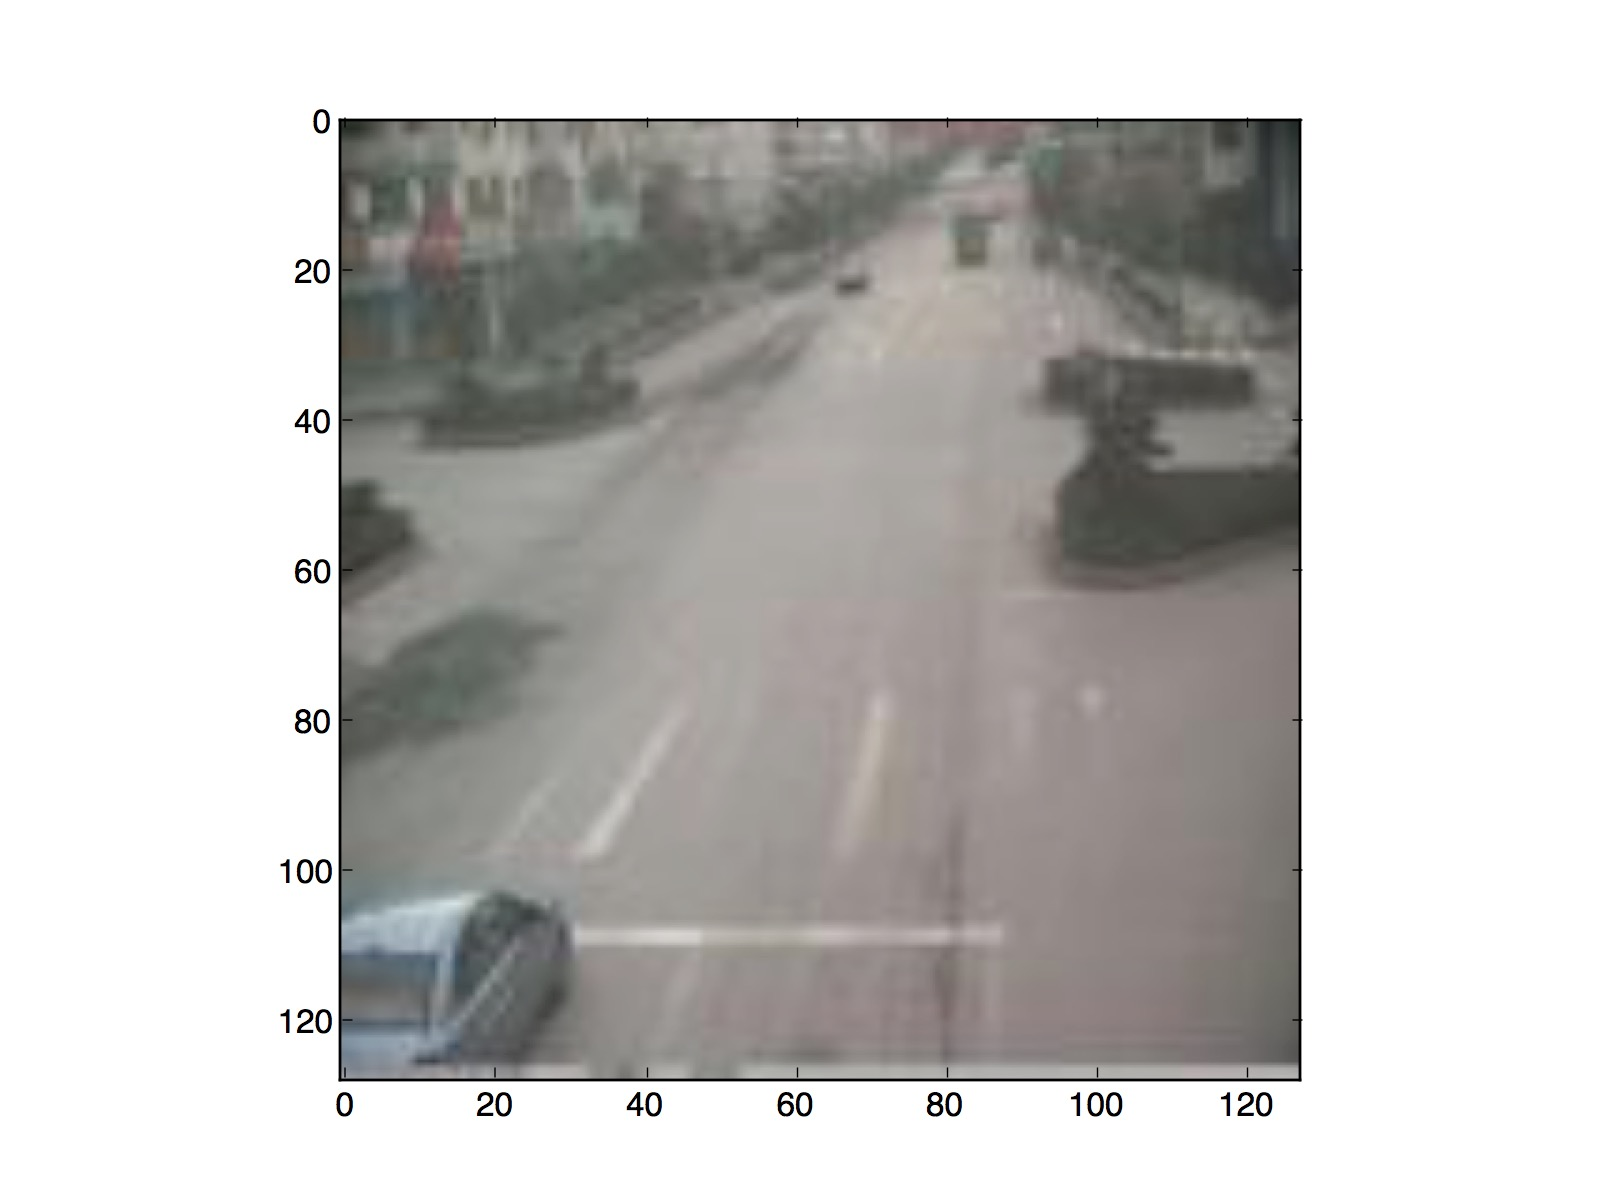

In [59]:
i = 326
img = original_test_dataset[i,:,:,:]

print TRUE_FALSE[i]
print predictions[i]
print labels[i]
plt.imshow(img)
plt.savefig('temp.jpg')
Image(filename='temp.jpg')